In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import efel

In [2]:
efel.get_feature_names()

['ADP_peak_amplitude',
 'ADP_peak_indices',
 'ADP_peak_values',
 'AHP1_depth_from_peak',
 'AHP2_depth_from_peak',
 'AHP_depth',
 'AHP_depth_abs',
 'AHP_depth_abs_slow',
 'AHP_depth_diff',
 'AHP_depth_from_peak',
 'AHP_depth_slow',
 'AHP_slow_time',
 'AHP_time_from_peak',
 'AP1_amp',
 'AP1_begin_voltage',
 'AP1_begin_width',
 'AP1_peak',
 'AP1_width',
 'AP2_AP1_begin_width_diff',
 'AP2_AP1_diff',
 'AP2_AP1_peak_diff',
 'AP2_amp',
 'AP2_begin_voltage',
 'AP2_begin_width',
 'AP2_peak',
 'AP2_width',
 'AP_amplitude',
 'AP_amplitude_change',
 'AP_amplitude_diff',
 'AP_amplitude_from_voltagebase',
 'AP_begin_indices',
 'AP_begin_time',
 'AP_begin_voltage',
 'AP_begin_width',
 'AP_duration',
 'AP_duration_change',
 'AP_duration_half_width',
 'AP_duration_half_width_change',
 'AP_end_indices',
 'AP_fall_indices',
 'AP_fall_rate',
 'AP_fall_rate_change',
 'AP_fall_time',
 'AP_height',
 'AP_peak_downstroke',
 'AP_peak_upstroke',
 'AP_phaseslope',
 'AP_rise_indices',
 'AP_rise_rate',
 'AP_rise_ra

In [3]:
efel.api.set_setting("strict_stiminterval", False)
efel.api.set_setting("interp_step", 0.02)

In [9]:
print(efel.get_settings())

Threshold: -20.0
DerivativeThreshold: 10.0
DownDerivativeThreshold: -12.0
dependencyfile_path: /Users/han.hou/miniconda3/envs/patch-seq/lib/python3.10/site-packages/efel/DependencyV5.txt
spike_skipf: 0.1
max_spike_skip: 2
interp_step: 0.02
burst_factor: 1.5
strict_burst_factor: 2.0
voltage_base_start_perc: 0.9
voltage_base_end_perc: 1.0
current_base_start_perc: 0.9
current_base_end_perc: 1.0
rise_start_perc: 0.0
rise_end_perc: 1.0
initial_perc: 0.1
min_spike_height: 20.0
strict_stiminterval: False
initburst_freq_threshold: 50
initburst_sahp_start: 5
initburst_sahp_end: 100
DerivativeWindow: 3
voltage_base_mode: mean
current_base_mode: mean
precision_threshold: 1e-10
sahp_start: 5.0
ignore_first_ISI: True
impedance_max_freq: 50.0
AP_phaseslope_range: 2
inactivation_tc_end_skip: 10


In [5]:
[f for f in efel.get_feature_names() if "width" in f]

['AP1_begin_width',
 'AP1_width',
 'AP2_AP1_begin_width_diff',
 'AP2_begin_width',
 'AP2_width',
 'AP_begin_width',
 'AP_duration_half_width',
 'AP_duration_half_width_change',
 'AP_width',
 'AP_width_between_threshold',
 'APlast_width',
 'spike_half_width',
 'spike_width2']

In [10]:
from LCNE_patchseq_analysis.data_util.nwb import PatchSeqNWB

sweep_number = 129

# Load an example NWB file
raw = PatchSeqNWB(ephys_roi_id="1408897096")

# Get trace and time for sweep 0 
trace = raw.get_raw_trace(sweep_number)
time = raw.dt_ms * np.arange(len(trace))
stim_start = raw.df_sweeps.query("sweep_number == @sweep_number")["stimulus_start_time"].values[0] * 1000
stim_end = stim_start + raw.df_sweeps.query("sweep_number == @sweep_number")["stimulus_duration"].values[0] * 1000

# Use efel to get features
traces = [
    {
        "T": time,
        "V": trace,
        "stim_start": [stim_start],
        "stim_end": [stim_end],
    }
]
df_features = pd.DataFrame(efel.get_feature_values(traces, efel.get_feature_names(), raise_warnings=False))
time_interpolated = df_features["time"][0]


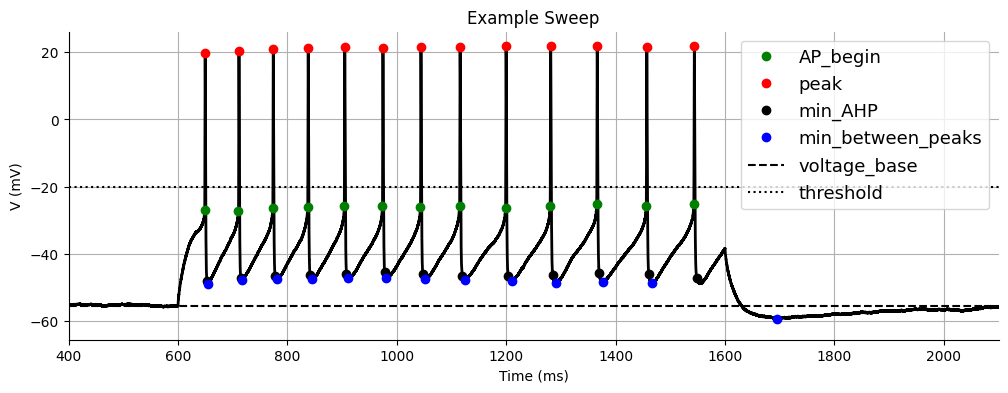

In [11]:

# Plot the trace
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(time, trace, 'k-', lw=2)
ax.plot(df_features["AP_begin_time"][0],
        df_features["AP_begin_voltage"][0], "go",
        label="AP_begin")
ax.plot(df_features["peak_time"][0], df_features["peak_voltage"][0], "ro",
        label="peak")
ax.plot([time_interpolated[ind] for ind in df_features["min_AHP_indices"][0]],
         df_features["min_AHP_values"][0], "ko",
         label="min_AHP")

# ["min_between_peaks_indices"]
ax.plot([time_interpolated[ind] for ind in df_features["min_between_peaks_indices"][0]],
         df_features["min_between_peaks_values"][0], "bo",
         label="min_between_peaks")

ax.axhline(df_features["voltage_base"][0], color="k", linestyle="--", label="voltage_base")

# Threshold
threshold = efel.get_settings().Threshold
ax.axhline(threshold, color="k", linestyle=":", label="threshold")

# for i in range(df_features["spike_count"][0][0] - 1):
#     ax.axhline(df_features["depolarized_base"][0][i], color="k", linestyle="--")
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
ax.set_title('Example Sweep')
ax.set_xlim(stim_start - 200, stim_end + 500)
# ax.set_xlim([1400, 1500])
ax.legend(loc="best", fontsize=13)
ax.grid(True)

sns.despine()
plt.show()


In [12]:
def five_point_stencil_derivative(x, t):
    """
    Compute the derivative of a discrete signal x with corresponding time t
    using the five-point centered difference for interior points.
    
    For the boundaries, a simple two-point difference is used.
    
    Parameters:
        x : array-like
            Discrete signal values.
        t : array-like
            Corresponding time stamps (assumed uniformly spaced).
            
    Returns:
        dx : numpy array
            Approximated derivative of x with respect to t.
    """
    x = np.array(x)
    t = np.array(t)
    
    # Assume uniform spacing
    h = t[1] - t[0]
    
    # Initialize the derivative array
    dx = np.zeros_like(x)
    
    # Use the five-point centered difference for interior points
    # This is valid for indices 2 to len(x)-3
    for i in range(2, len(x) - 2):
        dx[i] = (-x[i+2] + 8*x[i+1] - 8*x[i-1] + x[i-2]) / (12 * h)
    
    # For the boundaries where the five-point formula cannot be applied, use lower-order differences:
    dx[0] = (x[1] - x[0]) / (t[1] - t[0])  # forward difference
    dx[1] = (x[2] - x[1]) / (t[2] - t[1])
    dx[-2] = (x[-2] - x[-3]) / (t[-2] - t[-3])
    dx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
    
    return dx

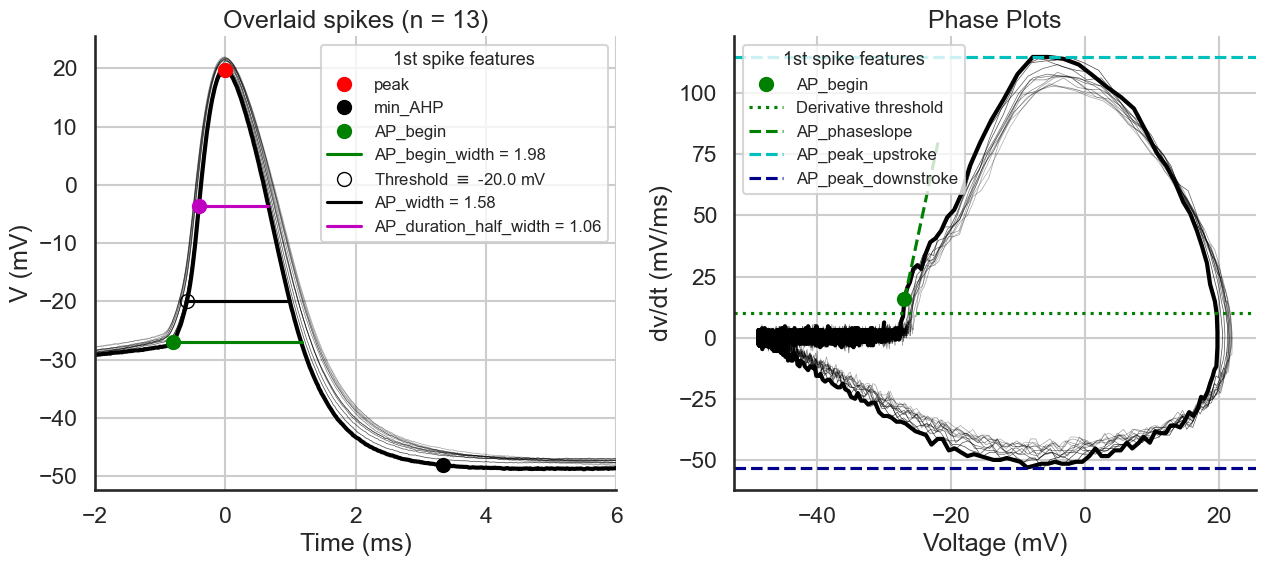

In [60]:
# Plot individual spikes overlaid with some features

sns.set_style("white")
sns.set_context("talk")

# peak_times = df_features["peak_time"][0]
time_interpolated = df_features["time"][0]
peak_times = [time_interpolated[ind] for ind in df_features["peak_indices"][0]]

BEGIN_OFFSET = 2  # ms between begin_time to the eFEL AP_begin_time
begin_times = [time_interpolated[ind] - BEGIN_OFFSET for ind in df_features["AP_begin_indices"][0]]
end_times = begin_times[1:]  # From this begin to the start of tne next begin
end_times.append(stim_end)

n_spikes = len(peak_times)
alphas = 0.8 * np.exp(-np.arange(n_spikes)/n_spikes)

fig, axs = plt.subplots(1, 2, figsize=(13, 6))

window = [-2, 6]  # Time window around a spike

ax_v, ax_phase = axs

# Plot the features for the first spike
for i, (begin_time, end_time, peak_time) in reversed(list(enumerate(zip(begin_times, end_times, peak_times)))):
    # Get the trace around the spike
#     start_time = peak_time + window[0]
#     end_time = peak_time + window[1]
    idx = np.where((time >= begin_time) & (time <= end_time))[0]
    t = time[idx] - peak_time  # Center the time on the spike
    v = trace[idx]
    
    dvdt = np.gradient(v, t)
    # dvdt = five_point_stencil_derivative(v, t) # eFEL uses this

    if i > 0:
        # Only overlay the traces for following spikes with a lower opacity
        ax_v.plot(t, v, 'k', lw=0.5, alpha=alphas[i])
        
        # Plot the phase plot
        ax_phase.plot(v, dvdt, 'k', lw=0.5, alpha=alphas[i])
        continue

    # Plot the trace with some key features
    ax_v.plot(t, v, 'k', lw=3)
    ax_phase.plot(v, dvdt, 'k', lw=3)

    # Plot the peak
    ax_v.plot(0, df_features["peak_voltage"][0][i], "ro",
            label="peak", ms=10)

    # min_AHP
    ax_v.plot([time_interpolated[df_features["min_AHP_indices"][0][i]]] - peak_time,
            df_features["min_AHP_values"][0][i], "ko",
            label="min_AHP", ms=10)

    # AP_end
#     ax_v.axvline(time_interpolated[df_features["AP_end_indices"][0][i]] - peak_time,
#            color="b", label="AP_end")

    # AP_begin
    # Spike start is defined as where the first derivative of the voltage trace is higher than 10 V/s, for at least 5 points    
    t_begin = df_features["AP_begin_time"][0][i] - peak_time
    v_begin = df_features["AP_begin_voltage"][0][i]
    ax_v.plot(t_begin, v_begin, "go", label="AP_begin", ms=10)
    
    # AP_begin_width
    # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-begin-width-ap1-begin-width-ap2-begin-width
    AP_begin_width = df_features["AP_begin_width"][0][i]        
    ax_v.plot([t_begin, t_begin + AP_begin_width],
            [v_begin, v_begin], "g-", label=f"AP_begin_width = {AP_begin_width:.2f}")

    # AP_width
    # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-width
    threshold = efel.get_settings().Threshold
    threshold_time_idx = np.where(v >= threshold)[0][0]
    threshold_time = t[threshold_time_idx]
    AP_width = df_features["AP_width"][0][i]
    ax_v.plot(threshold_time, threshold, "ko", fillstyle="none", ms=10, label=f"Threshold $\equiv$ {threshold} mV")
    ax_v.plot([threshold_time, threshold_time + AP_width],
            [threshold, threshold], "k-", label=f"AP_width = {AP_width:.2f}")

    # AP_width_between_threshold
    # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-width-between-threshold
    # Should be the same as AP_width for most cases

    # AP_duration_half_width
    # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-duration-half-width
    half_rise_time = time_interpolated[df_features["AP_rise_indices"][0][i]] - peak_time
#     half_fall_time = time_interpolated[df_features["AP_fall_indices"][0][i]] - peak_time
    half_voltage = (df_features["AP_begin_voltage"][0][i] + df_features["peak_voltage"][0][i]) / 2
    AP_duration_half_width = df_features["AP_duration_half_width"][0][i]
    ax_v.plot(half_rise_time, half_voltage, "mo", ms=10)
    ax_v.plot([half_rise_time, half_rise_time + AP_duration_half_width],
              [half_voltage, half_voltage], "m-", label=f"AP_duration_half_width = {AP_duration_half_width:.2f}")
    
    # Phase plot: phaseslope
    begin_ind = np.where(t >= t_begin)[0][0]
    ax_phase.plot(v[begin_ind], dvdt[begin_ind], 'go', ms=10, label="AP_begin")
    ax_phase.axhline(efel.get_settings().DerivativeThreshold, color="g", linestyle=":", label="Derivative threshold")
    
    # Phase plot: AP_phaseslope
    xx = np.linspace(v[begin_ind], v[begin_ind] + 5, 100)
    yy = dvdt[begin_ind] + (xx - v[begin_ind]) * df_features["AP_phaseslope"][0][i]
    ax_phase.plot(xx, yy, "g--", label=f"AP_phaseslope")
    
    # Phase plot: AP_peak_upstroke
    ax_phase.axhline(df_features["AP_peak_upstroke"][0][i], color="c", linestyle="--", label="AP_peak_upstroke")
    
    # Phase plot: AP_peak_downstroke
    ax_phase.axhline(df_features["AP_peak_downstroke"][0][i], color="darkblue", linestyle="--", label="AP_peak_downstroke")
    
# For 1D array or single subplot
ax_v.set_xlim(-BEGIN_OFFSET, 6)
ax_v.set_xlabel('Time (ms)')
ax_v.set_ylabel('V (mV)')
ax_v.set_title(f'Overlaid spikes (n = {n_spikes})')
ax_v.legend(loc="best", fontsize=12, title="1st spike features", title_fontsize=13)  # Outside the plot
ax_v.grid(True)

ax_phase.set_xlabel('Voltage (mV)')
ax_phase.set_ylabel('dv/dt (mV/ms)')
ax_phase.set_title('Phase Plots')
ax_phase.legend(loc="best", fontsize=12, title="1st spike features", title_fontsize=13)  # Outside the plot
ax_phase.grid(True)

fig.tight_layout()
sns.despine()


In [51]:
df_features["AP_peak_upstroke"]

0    [114.84375000010445, 114.84374997223341, 113.2...
Name: AP_peak_upstroke, dtype: object

In [392]:
df_features["AP_duration_half_width"][0]

array([1. , 1.1, 1.2, 1.1, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.3, 1.2, 1.2])

In [240]:
df_features["AP_rise_indices"][0]

array([ 6494,  7111,  7738,  8377,  9045,  9743, 10438, 11153, 11993,
       12809, 13659, 14566, 15435])

In [193]:
features[0]["min_between_peaks_indices"]

array([ 6554,  7161,  7803,  8430,  9132,  9814, 10518, 11252, 12093,
       12912, 13761, 14688, 16943])

In [194]:
features[0]["min_AHP_indices"]

array([ 6535,  7157,  7799,  8430,  9092,  9791, 10487, 11210, 12062,
       12879, 13734, 14629, 15526])

In [26]:
raw.df_sweeps.query("sweep_number == 129")["stimulus_start_time"]

100    0.6
Name: stimulus_start_time, dtype: float64